<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-Test-Model" data-toc-modified-id="Load-Test-Model-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load Test Model</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Extract-useful-info-from-the-model-object" data-toc-modified-id="Extract-useful-info-from-the-model-object-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>Extract useful info from the model object</a></span></li><li><span><a href="#Generate-artifical-data" data-toc-modified-id="Generate-artifical-data-1.0.2"><span class="toc-item-num">1.0.2&nbsp;&nbsp;</span>Generate artifical data</a></span></li></ul></li></ul></li><li><span><a href="#Aesara-graph" data-toc-modified-id="Aesara-graph-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Aesara graph</a></span><ul class="toc-item"><li><span><a href="#Solve-for-Steady-State" data-toc-modified-id="Solve-for-Steady-State-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Solve for Steady State</a></span></li><li><span><a href="#Solve-for-First-Order-Linearized-Policy-Matrices-via-Cycle-Reduction" data-toc-modified-id="Solve-for-First-Order-Linearized-Policy-Matrices-via-Cycle-Reduction-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Solve for First Order Linearized Policy Matrices via Cycle Reduction</a></span><ul class="toc-item"><li><span><a href="#Sanity-Check:-Impulse-Response-Functions-from-T,-R" data-toc-modified-id="Sanity-Check:-Impulse-Response-Functions-from-T,-R-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>Sanity Check: Impulse Response Functions from T, R</a></span></li><li><span><a href="#Confirm-we-have-end-to-end-gradients-of-the-system-w.r.t.-deep-parameters" data-toc-modified-id="Confirm-we-have-end-to-end-gradients-of-the-system-w.r.t.-deep-parameters-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>Confirm we have end-to-end gradients of the system w.r.t. deep parameters</a></span></li></ul></li><li><span><a href="#Kalman-Filter" data-toc-modified-id="Kalman-Filter-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Kalman Filter</a></span><ul class="toc-item"><li><span><a href="#Compute-log-likelihood-of-the-data" data-toc-modified-id="Compute-log-likelihood-of-the-data-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Compute log likelihood of the data</a></span></li><li><span><a href="#Check-gradients-of-the-log-likelihood-w.r.t.-deep-parameters" data-toc-modified-id="Check-gradients-of-the-log-likelihood-w.r.t.-deep-parameters-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Check gradients of the log likelihood w.r.t. deep parameters</a></span></li></ul></li></ul></li></ul></div>

In [1]:
from gEcon.classes.model import gEconModel
import numpy as np
import pandas as pd
import aesara
import aesara.tensor as at
from aesara.compile.builders import OpFromGraph
from aesara.scan.utils import until as scan_until

import sympy as sp
from sympy.printing.aesaracode import aesara_code

import matplotlib.pyplot as plt
config = {'figure.figsize':(14,4),
          'figure.dpi':100,
          'figure.facecolor':'w',
          'axes.grid':True,
          'grid.linewidth':0.5,
          'grid.linestyle':'--',
          'axes.spines.top':False,
          'axes.spines.bottom':False,
          'axes.spines.left':False,
          'axes.spines.right':False}

plt.rcParams.update(config)


# Load Test Model

Use a baseline RBC, and solve it with the numpy/sympy code as a baseline

In [2]:
model = gEconModel('tests/Test GCNs/Two_Block_RBC_1.gcn')
model.steady_state()
model.solve_model()

Model Building Complete.
Found:
	13 equations
	13 variables
	1 stochastic shock
		 0 / 1 has a defined prior. 
	6 parameters
		 0 / 6 has a defined prior. 
	0 calibrating equations
	0 parameters to calibrate
 Model appears well defined and ready to proceed to solving.

Steady state found! Sum of squared residuals is 6.226407420419094e-24
Solution found, sum of squared residuals:  7.075155451456433e-30
Norm of deterministic part: 0.000000000
Norm of stochastic part:    0.000000000


### Extract useful info from the model object

In [3]:
n_variables = model.n_variables
param_dict = model.free_param_dict.copy()
ss_system = model.steady_state_solver.steady_state_system
all_vars = sorted(model.variables, key=lambda x: x.name)
ss_vars = [x.to_ss() for x in all_vars]

params_as_symbols = [sp.Symbol(x) for x in model.free_param_dict.keys()]

Fs = model._perturbation_setup(not_loglin_variable=None, order=1, model_is_linear=False, verbose=False, return_F_matrices=True)

### Generate artifical data

In [4]:
observed_vars = ['Y']

fake_observed = (model.simulate(simulation_length=100, n_simulations=1, shock_cov_matrix=np.eye(1) * 0.1)
                      .droplevel(axis=1, level=1)
                      .sort_index(axis=1)
                      .T
                      .loc[:, observed_vars])

n_obs = len(observed_vars)
Z = np.zeros((n_obs, model.n_variables))
Z_mask = [x.base_name in observed_vars for x in sorted(model.variables, key=lambda x: x.base_name)]
Z[np.arange(n_obs), Z_mask] = 1

# Aesara graph

In [5]:
cache_dict = {}

aesara_vars_ss = [aesara_code(x, cache=cache_dict) for x in ss_vars]
aesara_params = [aesara_code(x, cache=cache_dict) for x in params_as_symbols]

aesara_items = aesara_params + aesara_vars_ss

aesara_ss_system = at.stack([aesara_code(eq, cache=cache_dict) for eq in ss_system])
jacobian_ss = sp.Matrix([[eq.diff(x) for x in ss_vars] for eq in ss_system])
aesara_jac = aesara_code(jacobian_ss, cache=cache_dict)

A = aesara_code(Fs[0], cache=cache_dict)
B = aesara_code(Fs[1], cache=cache_dict)
C = aesara_code(Fs[2], cache=cache_dict)
D = aesara_code(Fs[3], cache=cache_dict).astype('float64')

## Solve for Steady State 

In [6]:
step_size = at.dscalar('step_size')
ss_max_iter = at.iscalar('ss_max_iter')
ss_tol  = at.dscalar('ss_tol')

F_ss = OpFromGraph(aesara_items, [aesara_ss_system], name='F_ss', on_unused_input='ignore')
J_ss = OpFromGraph(aesara_items, [aesara_jac], name='J_ss', on_unused_input='ignore')

def newton_step(X, old_F, old_J, n_steps, params, step_size, tol):
    
    new_X = X - step_size * at.linalg.solve(old_J, old_F)
    new_F = F_ss(*params, *[new_X[i] for i in range(n_variables)])
    new_J = J_ss(*params, *[new_X[i] for i in range(n_variables)])
    n_steps += 1
    
    return (new_X, new_F, new_J, n_steps), scan_until(at.linalg.norm(new_F, ord=1) < tol)

# Initial values
F0 = F_ss(*aesara_items)
J0 = J_ss(*aesara_items)

# Scan
result, updates = aesara.scan(newton_step,
                              outputs_info=[aesara_vars_ss, F0, J0, at.zeros(1)],
                              non_sequences=[aesara_params, step_size, ss_tol],
                              n_steps=ss_max_iter)

roots, resids, jacobains, n_step = result
root = roots[-1]
resid = resids[-1]
jac = jacobains[-1]
n = n_step[-1]

## Solve for First Order Linearized Policy Matrices via Cycle Reduction

In [7]:
F_A = OpFromGraph(aesara_items, [A], on_unused_input='ignore', name='F_A')
F_B = OpFromGraph(aesara_items, [B], on_unused_input='ignore', name='F_B')
F_C = OpFromGraph(aesara_items, [C], on_unused_input='ignore', name='F_C')
F_D = OpFromGraph(aesara_items, [D], on_unused_input='ignore', name='F_D')

In [8]:
def cycle_step(A, B, B_hat, C, tol):
    n, _ = A.shape
    idx_0 = at.arange(n)
    idx_1 = idx_0 + n
    
    AC_tall = at.concatenate([A, C], axis=0)
    AC_wide = at.concatenate([A, C], axis=1)
    
    temp = AC_tall.dot(at.linalg.solve(B, AC_wide))
    new_B = B - temp[idx_0, :][:, idx_1] - temp[idx_1, :][:, idx_0]
    new_A = -temp[idx_0, :][:, idx_0]
    new_C = -temp[idx_1, :][:, idx_1]
    new_B_hat = B_hat - temp[idx_1, :][:, idx_0]
    
    A_norm = at.linalg.norm(new_A, ord=1)
    C_norm = at.linalg.norm(new_C, ord=1)
    
    return (new_A, new_B, new_B_hat, new_C), scan_until((A_norm < tol) & (C_norm < tol))

cycle_tol = at.dscalar(name='cycle_tol')
cycle_max_iter = at.iscalar(name='cycle_max_iter')

A0 = F_A(*aesara_params, *[root[i] for i in range(n_variables)])
B0 = F_B(*aesara_params, *[root[i] for i in range(n_variables)])
C0 = F_C(*aesara_params, *[root[i] for i in range(n_variables)])
D0 = F_D(*aesara_params, *[root[i] for i in range(n_variables)])

cycle_result, cycle_updates = aesara.scan(cycle_step,
                                         outputs_info=[A0, B0, B0, C0],
                                         non_sequences=[cycle_tol],
                                         n_steps=cycle_max_iter)

_, _, B_hat_final, _ = cycle_result
B_hat_solved = B_hat_final[-1]

T = -at.linalg.solve(B_hat_solved, A0)
resids = at.sqr(A0 + B0.dot(T) + C0.dot(T).dot(T)).sum()
R = -at.linalg.inv(C0.dot(T) + B0).dot(D0)

### Sanity Check: Impulse Response Functions from T, R

In [9]:
ss_optim_kwargs = {'step_size':1.0, 'ss_tol':1e-12, 'ss_max_iter':100}
cycle_kwargs = {'cycle_tol':1e-12, 'cycle_max_iter':1000}
x0_dict = {x.name: 0.8 for x in ss_vars}

In [10]:
all_aesara_inputs = aesara_items + [ss_max_iter, ss_tol, step_size, cycle_max_iter, cycle_tol]
F_TR = aesara.function(all_aesara_inputs, [T, R], on_unused_input='ignore', name='first_order_solution')

T_np, R_np = F_TR(**param_dict, **x0_dict, **ss_optim_kwargs, **cycle_kwargs)

timesteps = 100
shocks = np.zeros((timesteps, 1))
shocks[10] = 1.0
simulation = np.zeros((timesteps, n_variables))
for t in range(1, timesteps):
    simulation[t, :] = T_np @ simulation[t-1, :] + R_np @ shocks[t]

WARNING (aesara.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


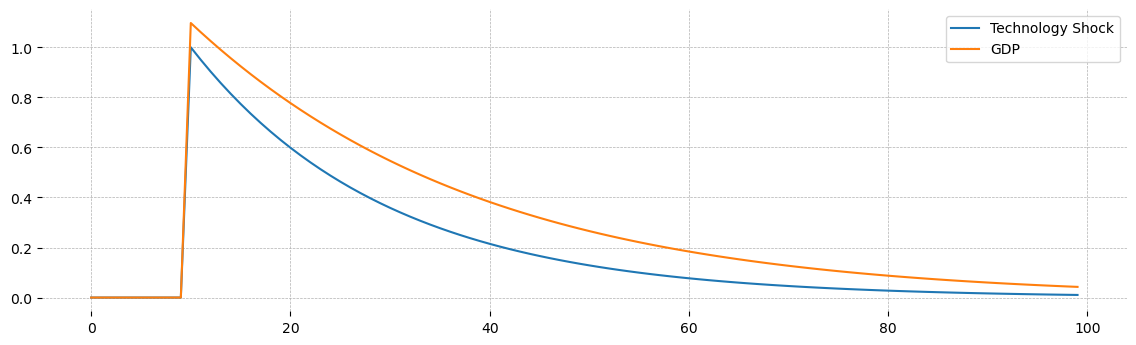

In [11]:
fig, ax = plt.subplots(figsize=(14,4), dpi=100)
plt.plot(simulation[:, 0], label='Technology Shock')
plt.plot(simulation[:, 8], label='GDP')
fig.set_facecolor('w')
ax.legend()
plt.show()

In [12]:
# The shock process should be A[t+1] = rho_A * A[t] + epsilon[t], we can check it is coming out correctly.
np.allclose(simulation[10:, 0], 0.95 ** np.arange(90))

True

### Confirm we have end-to-end gradients of the system w.r.t. deep parameters

In [13]:
at.grad(resids, aesara_params)

[Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0,
 Elemwise{add,no_inplace}.0]

## Kalman Filter

In [14]:
def kalman_step(y, a, P, ll, Q, H, T, R, Z):
    v = y - Z.dot(a)
    F = Z.dot(P).dot(Z.T) + H
    F_inv = at.linalg.solve(F, at.eye(F.shape[0]))

    a_update = a + P.dot(Z.T).dot(F_inv).dot(v)
    P_update = P - P.dot(Z.T).dot(F_inv).dot(Z).dot(P)

    a_hat = T.dot(a_update)
    P_hat = T.dot(P_update).dot(T.T) + R.dot(Q).dot(R.T)

    ll = ((at.log(at.linalg.det(F)) + (v.T)).dot(F_inv).dot(v))

    return a_hat, P_hat, ll[0]

data = at.dmatrix('data')
a0  = at.dmatrix('a0')
P0 = at.dmatrix('P0')

# sigma_epsilon_A = at.dscalar('sigma_epsilon_A')

ae_Z = at.dmatrix('Z')
H = at.dmatrix('H')
Q = at.dmatrix('Q')

kalman_results, updates = aesara.scan(kalman_step,
                               sequences=[data],
                               outputs_info=[a0, P0, at.zeros((ae_Z.shape[0],))],
                               non_sequences=[Q, H, T, R, ae_Z])

states, covariances, log_likelihoods = kalman_results
log_likelihood = -data.shape[0] * data.shape[1] / 2 * at.log(2 * np.pi) - 0.5 * log_likelihoods.sum()

### Compute log likelihood of the data

In [15]:
f_ll = aesara.function(all_aesara_inputs + [data, a0, P0, ae_Z, H, Q], [log_likelihood])

WARNING (aesara.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


In [16]:
f_ll(**param_dict, **x0_dict, **ss_optim_kwargs, **cycle_kwargs,
    data=fake_observed.values,
    a0=np.zeros((13,1)), 
     P0=model.compute_stationary_covariance_matrix().values,
     Z=Z, 
     H=np.zeros((1,1)), 
     Q=np.eye(1) * 0.1)

[array(-164.03745044)]

### Check gradients of the log likelihood w.r.t. deep parameters

Can't get gradients of the deep parameters; only of the "shallow" ones. What is not implemented?

In [17]:
at.grad(log_likelihood, aesara_params)

NotImplementedError: 

In [18]:
at.grad(log_likelihood, a0)

InplaceDimShuffle{1,2}.0